# Code to reproduce the volcano plot and heatmap from the paper: Analysis of genes associated with prognosis of lung adenocarcinoma based on GEO and TCGA databases 

# Part 1: R-script to obtain the differentially expressed genes using the limma library

In [ ]:
#importing librariers
library(limma)
library(GEOquery)
library(dplyr)

#creating a matrix with the expression data using the getGEO function from the GEOquery library.
#we need to load series and platform data from GEO and therefore we use this function. 
gset <- getGEO("GSE118370", GSEMatrix =TRUE, AnnotGPL=TRUE)
if (length(gset) > 1) idx <- grep("GPL570", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

#making proper column names to match toptable which will be used to get the list of DEGs
fvarLabels(gset) <- make.names(fvarLabels(gset))

#assigning a phenotype to all samples 
gsms <- "011001010101"
sml <- strsplit(gsms, split="")[[1]]

#performing log2 transformation before obtaining DEGs
ex <- exprs(gset)
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) || 
  (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { ex[which(ex <= 0)] <- NaN
exprs(gset) <- log2(ex) }

#assigning samples to their respective groups (normal and cancer) and setting up a design matrix
gs <- factor(sml)
groups <- make.names(c("cancer","normal"))
levels(gs) <- groups
gset$group <- gs
design <- model.matrix(~group + 0, gset)
colnames(design) <- levels(gs)

#fitting the linear model with the expression data matrix and design matrix
fit <- lmFit(gset, design)  

#setting up contrasts of interest and recalculating model coefficients
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

#computing the statistics and table of top significant genes (aka differentially expressed genes)

#eBayes given a microarray linear model fit, computes moderated t-statistics, moderated F-statistic, 
#and log-odds of differential expression by empirical Bayes moderation of the standard errors towards a common value.
fit2 <- eBayes(fit2)  

#this gives us the p-values and p-adjusted values for all the genes
all_genes <- topTable(fit2, adjust = "fdr", number = Inf) 
all_genes_1 <- select(all_genes, ID, Gene.symbol,Gene.ID, logFC, AveExpr, t, P.Value, adj.P.Val, B) #selecting only the columns that I require

#this gives us the p-values and p-adjusted values for the significant genes because we set a p-value and lfc cutoff values
sig_genes <- topTable(fit2,lfc = log2(4), p.value = 0.05, adjust = "fdr", number = Inf) 
sig_genes_1 <- select(sig_genes, ID, Gene.symbol, logFC, AveExpr, t, P.Value, adj.P.Val, B)

#saving the files
write.csv(sig_genes_1, "selected_degs_1.csv")
write.csv(all_genes_1, "all_genes.csv") 

# Part 2: Python script to reproduce the volcano plot 

In [45]:
#importing the libraries 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import random

In [46]:
#reading the file that has the computed statistics for all genes (obtained from the R-script)
df1 = pd.read_csv('all_genes.csv')
df1.rename(columns = {'adj.P.Val':'padj', 'Gene.symbol':'symbol', 'P.Value':'pval'}, inplace = True) #renaming the columns
df1['nlog10'] = -np.log10(df1.pval) #calculating the negative nlog10 value for all the p-values and adding it as a new column in the dataframe
df1.head() 

,Unnamed: 0,ID,symbol,Gene.ID,logFC,AveExpr,t,pval,padj,B,nlog10
0,1563327_a_at,1563327_a_at,LINC01545,724087,-3.865512,5.372024,-12.109463,2.525173e-08,0.000946,8.951309,7.597709
1,204677_at,204677_at,CDH5,1003,-2.495439,10.178252,-11.331786,5.470865e-08,0.000946,8.337435,7.261944
2,230469_at,230469_at,RTKN2,219790,-3.797260,9.474660,-11.196297,6.288114e-08,0.000946,8.224914,7.201480
3,242009_at,242009_at,SLC6A4,6532,-6.180711,10.358953,-10.930990,8.292724e-08,0.000946,7.999546,7.081303
4,204271_s_at,204271_s_at,EDNRB,1910,-3.381801,10.894820,-10.704026,1.055421e-07,0.000946,7.801314,6.976574


Part 1: Using only the logFC and p-value parameters to plot

In [47]:
#the upregulated genes will have a logFC of greater than 2 and p-value less than 0.05
up_reg_genes = df1[(df1.logFC.gt(2)) & (df1.pval.lt(0.05))] 
#the downregulated genes will have a logFC of less than 2 and p-value less than 0.05
down_reg_genes = df1[(df1.logFC.lt(-2)) & (df1.pval.lt(0.05))]

#printing the length 
print(len(up_reg_genes))
print(len(down_reg_genes))

518
1080


In [48]:
#converting the ID column from both the dataframes to two lists
up_reg_genes_list = up_reg_genes.ID.tolist()
down_reg_genes_list = down_reg_genes.ID.tolist()
   
#sanity check    
print(len(up_reg_genes_list))
print(len(down_reg_genes_list))

518
1080


In [49]:
#this function helps in distinguishing the genes in order to assign the right colors in the volcano plot   
def map_color(a):
    logFC, ID, nlog10 = a
    
    if abs(logFC) < 2 or nlog10 < (-np.log10(0.05)):
        return 'no change'
    if ID in up_reg_genes_list:
        return 'up'
    if ID in down_reg_genes_list:
        return 'down'
    return 'no change'

df1['color'] = df1[['logFC', 'ID', 'nlog10']].apply(map_color, axis = 1)

In [50]:
#sanity check
df1.loc[df1['color'] == 'up'].shape

(518, 12)

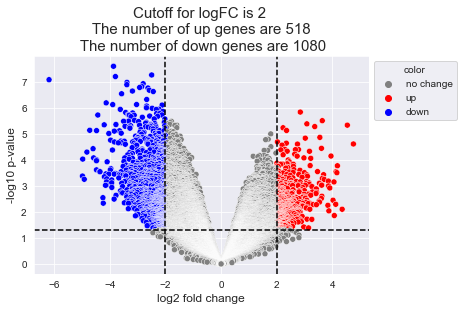

In [77]:
#plotting the Volcano plot
sns.set_style('darkgrid')
fig_1 = sns.scatterplot(data = df1, x='logFC', y='nlog10', 
                        hue = 'color', hue_order = ['no change', 'up', 'down'], 
                        palette = ['grey', 'red', 'blue'])

fig_1.axhline(y= (-np.log10(0.05)), c= 'k', linestyle = '--') #Adding a horizontal line for pval cutoff (-log10 of 0.05 is 1.30)

fig_1.axvline(x=2, c= 'k', linestyle = '--') #Adding a vertical line for the log2fc cutoff (2 and -2)
fig_1.axvline(x=-2, c= 'k', linestyle = '--') #Adding a vertical line for the log2fc cutoff (2 and -2)
sns.move_legend(fig_1, "upper left", bbox_to_anchor=(1, 1))
fig_1.set_title("Cutoff for logFC is 2 \n The number of up genes are 518 \n The number of down genes are 1080", fontsize= 15)
fig_1.set_xlabel("log2 fold change", fontsize=12)
fig_1.set_ylabel("-log10 p-value", fontsize=12)
plt.show()

Plot while applying logFC and adj p-value cutoffs

In [81]:
#the upregulated genes will have a logFC of greater than 2 and padj value less than 0.05
up_reg_genes_2 = df1[(df1.logFC.gt(2)) & (df1.padj.lt(0.05))]
#the downregulated genes will have a logFC of less than 2 and padj value less than 0.05
down_reg_genes_2 = df1[(df1.logFC.lt(-2)) & (df1.padj.lt(0.05))]

print(len(up_reg_genes_2))
print(len(down_reg_genes_2))

123
514


In [67]:
up_reg_genes_list_2 = up_reg_genes_2.ID.tolist()
down_reg_genes_list_2 = down_reg_genes_2.ID.tolist()
#this function helps in distinguishing the genes in order to assign the right colors in the volcano plot
def map_color_2(b):
    logFC, ID, nlog10 = b
    
    if abs(logFC) < 2 or nlog10 < (-np.log10(0.05)):
        return 'no change'
    if ID in up_reg_genes_list_2:
        return 'up'
    if ID in down_reg_genes_list_2:
        return 'down'
    return 'no change'


df1['color2'] = df1[['logFC', 'ID', 'nlog10']].apply(map_color_2, axis = 1)
df1.head()

,Unnamed: 0,ID,symbol,Gene.ID,logFC,AveExpr,t,pval,padj,B,nlog10,color,color2
0,1563327_a_at,1563327_a_at,LINC01545,724087,-3.865512,5.372024,-12.109463,2.525173e-08,0.000946,8.951309,7.597709,down,down
1,204677_at,204677_at,CDH5,1003,-2.495439,10.178252,-11.331786,5.470865e-08,0.000946,8.337435,7.261944,down,down
2,230469_at,230469_at,RTKN2,219790,-3.797260,9.474660,-11.196297,6.288114e-08,0.000946,8.224914,7.201480,down,down
3,242009_at,242009_at,SLC6A4,6532,-6.180711,10.358953,-10.930990,8.292724e-08,0.000946,7.999546,7.081303,down,down
4,204271_s_at,204271_s_at,EDNRB,1910,-3.381801,10.894820,-10.704026,1.055421e-07,0.000946,7.801314,6.976574,down,down


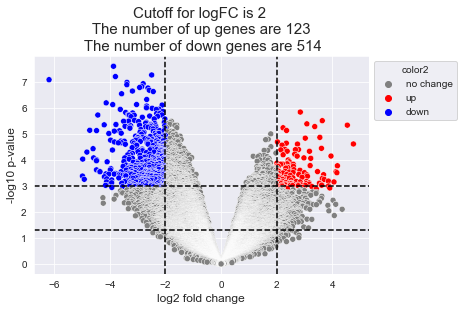

In [76]:
fig_2 = sns.scatterplot(data = df1, x='logFC', y='nlog10', 
                        hue = 'color2', hue_order = ['no change', 'up', 'down'], 
                        palette = ['grey', 'red', 'blue'])

fig_2.axhline(y= (-np.log10(0.05)), c= 'k', linestyle = '--') #add horizontal line for pval cutoff 
fig_2.axhline(y= 3, c= 'k', linestyle = '--') #add horizontal line for adj pval cutoff 
fig_2.axvline(x=2, c= 'k', linestyle = '--') #add vertical line for log2fc cutoff
fig_2.axvline(x=-2, c= 'k', linestyle = '--')
sns.move_legend(fig_2, "upper left", bbox_to_anchor=(1, 1))
fig_2.set_title("Cutoff for logFC is 2 \n The number of up genes are 123 \n The number of down genes are 514", fontsize= 15)
fig_2.set_xlabel("log2 fold change", fontsize=12)
fig_2.set_ylabel("-log10 p-value", fontsize=12)
plt.show()

# Part 3: Python script to reproduce the heatmap with hierarchical clustering

In [13]:
#importing packages 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import pickle
#packages required for hierarchical clustering
import scipy.spatial
import scipy.cluster
import pandas as pd
import seaborn as sns
import scipy.io
import csv

In [17]:
#importing the file that has the differentially expressed genes (~600 genes)
sig_genes_df=pd.read_csv("selected_degs_1.csv")
sig_genes_df.keys()

Index(['Unnamed: 0', 'ID', 'Gene.symbol', 'logFC', 'AveExpr', 't', 'P.Value',
       'adj.P.Val', 'B'],
      dtype='object')

In [18]:
sig_genes_df

,Unnamed: 0,ID,Gene.symbol,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,1563327_a_at,1563327_a_at,LINC01545,-3.865512,5.372024,-12.109463,2.525173e-08,0.000946,8.951309
1,204677_at,204677_at,CDH5,-2.495439,10.178252,-11.331786,5.470865e-08,0.000946,8.337435
2,230469_at,230469_at,RTKN2,-3.797260,9.474660,-11.196297,6.288114e-08,0.000946,8.224914
3,242009_at,242009_at,SLC6A4,-6.180711,10.358953,-10.930990,8.292724e-08,0.000946,7.999546
4,204271_s_at,204271_s_at,EDNRB,-3.381801,10.894820,-10.704026,1.055421e-07,0.000946,7.801314
...,...,...,...,...,...,...,...,...,...
632,234764_x_at,234764_x_at,IGLJ3///IGLV1-44///CKAP2///IGLV@///IGLC1,2.213101,9.022521,4.104209,1.314825e-03,0.049137,-0.849526
633,1560300_a_at,1560300_a_at,DMRTC1B///DMRTC1,2.123791,6.358378,4.100297,1.324343e-03,0.049392,-0.856476
634,239548_at,239548_at,NEGR1,-2.974559,5.677795,-4.091858,1.345117e-03,0.049892,-0.871474
635,237390_at,237390_at,ADRA1A,-2.441071,5.694249,-4.091438,1.346159e-03,0.049892,-0.872220


In [19]:
#importing the data that has the expression values for all the samples and all the genes 
overall_genes_df = pd.read_excel('overall_expression_data.xlsx')
overall_genes_df

,ID_REF,GSM3325818,GSM3325819,GSM3325820,GSM3325821,GSM3325822,GSM3325823,GSM3325824,GSM3325825,GSM3325826,GSM3325827,GSM3325828,GSM3325829
0,1007_s_at,11.895394,10.269245,10.065805,11.291417,11.802366,10.093049,12.031426,9.846327,11.294818,10.387100,11.358080,10.749565
1,1053_at,6.816687,6.504383,7.179516,3.300399,5.672110,5.181882,6.847892,4.644593,6.263927,5.809992,7.207723,5.339998
2,117_at,10.534546,9.789316,8.632564,8.843515,7.270362,9.016977,8.080441,8.913012,8.722642,8.638038,8.909750,8.693754
3,121_at,7.978451,7.734143,8.765379,8.345526,8.132303,8.127082,8.224374,8.376125,8.483086,8.901374,8.110718,6.559176
4,1255_g_at,7.224958,4.555631,2.431251,2.191050,3.032747,2.649330,3.141635,3.106930,6.371555,2.739549,3.525285,4.641659
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54670,AFFX-ThrX-5_at,4.645736,4.115289,3.114871,3.819215,2.227782,5.603631,3.469989,6.560362,5.726503,5.528619,5.173854,7.143432
54671,AFFX-ThrX-M_at,4.584568,3.156602,3.227373,5.114491,5.816650,2.995936,4.653057,2.947327,5.935310,6.261253,5.425517,2.329926
54672,AFFX-TrpnX-3_at,4.195908,3.560455,3.063986,6.498540,5.943571,5.841686,1.924594,3.399316,4.809190,4.614047,4.886932,6.698406
54673,AFFX-TrpnX-5_at,5.214241,5.366405,3.688014,2.432426,5.447862,5.449325,2.750158,2.947509,3.043515,5.313602,3.705296,5.122910


In [35]:
#renaming the 'ID_REF' column to 'ID' in order to get it similar to how it is in the sig_genes_df
#renaming the sample names to cancer and normal to understand the heatmap better
#if it is patient one, then it is Disease_1 and their corresponding normal/healthy tissue is Normal_1
overall_genes_df.rename(columns={"ID_REF":"ID", "GSM3325818":"Disease_1","GSM3325819":"Normal_1", "GSM3325820":"Normal_2","GSM3325821":"Disease_2", "GSM3325822" :"Disease_3", "GSM3325823":"Normal_3","GSM3325824":"Disease_4","GSM3325825":"Normal_4","GSM3325826":"Disease_5", "GSM3325827":"Normal_5", "GSM3325828":"Disease_6","GSM3325829":"Normal_6"},inplace=True)
overall_genes_df

,ID,Disease_1,Normal_1,Normal_2,Disease_2,Disease_3,Normal_3,Disease_4,Normal_4,Disease_5,Normal_5,Disease_6,Normal_6
0,1007_s_at,11.895394,10.269245,10.065805,11.291417,11.802366,10.093049,12.031426,9.846327,11.294818,10.387100,11.358080,10.749565
1,1053_at,6.816687,6.504383,7.179516,3.300399,5.672110,5.181882,6.847892,4.644593,6.263927,5.809992,7.207723,5.339998
2,117_at,10.534546,9.789316,8.632564,8.843515,7.270362,9.016977,8.080441,8.913012,8.722642,8.638038,8.909750,8.693754
3,121_at,7.978451,7.734143,8.765379,8.345526,8.132303,8.127082,8.224374,8.376125,8.483086,8.901374,8.110718,6.559176
4,1255_g_at,7.224958,4.555631,2.431251,2.191050,3.032747,2.649330,3.141635,3.106930,6.371555,2.739549,3.525285,4.641659
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54670,AFFX-ThrX-5_at,4.645736,4.115289,3.114871,3.819215,2.227782,5.603631,3.469989,6.560362,5.726503,5.528619,5.173854,7.143432
54671,AFFX-ThrX-M_at,4.584568,3.156602,3.227373,5.114491,5.816650,2.995936,4.653057,2.947327,5.935310,6.261253,5.425517,2.329926
54672,AFFX-TrpnX-3_at,4.195908,3.560455,3.063986,6.498540,5.943571,5.841686,1.924594,3.399316,4.809190,4.614047,4.886932,6.698406
54673,AFFX-TrpnX-5_at,5.214241,5.366405,3.688014,2.432426,5.447862,5.449325,2.750158,2.947509,3.043515,5.313602,3.705296,5.122910


In [36]:
#creating another dataframe by merging overall_genes_df and sig_genes_df in order to get the count values for only the sig_genes
#merging on the 'ID' column
#the merged_df dataframe will have the same number of rows as sig_genes_df and the # of columns is the total of both the dataframes
merged_df = pd.merge(sig_genes_df,overall_genes_df, on=['ID'],how="left")
merged_df

,Unnamed: 0,ID,Gene.symbol,logFC,AveExpr,t,P.Value,adj.P.Val,B,Disease_1,...,Normal_2,Disease_2,Disease_3,Normal_3,Disease_4,Normal_4,Disease_5,Normal_5,Disease_6,Normal_6
0,1563327_a_at,1563327_a_at,LINC01545,-3.865512,5.372024,-12.109463,2.525173e-08,0.000946,8.951309,3.119734,...,7.884571,3.768585,3.726142,7.728314,3.373365,7.879256,3.932279,6.951254,2.715499,6.680917
1,204677_at,204677_at,CDH5,-2.495439,10.178252,-11.331786,5.470865e-08,0.000946,8.337435,8.576245,...,11.617961,8.836267,9.159417,11.367052,8.961206,11.316625,9.403835,11.795254,8.646223,11.243467
2,230469_at,230469_at,RTKN2,-3.797260,9.474660,-11.196297,6.288114e-08,0.000946,8.224914,6.379227,...,11.803315,8.501473,7.330779,11.318059,7.664429,10.875235,7.673476,11.907375,7.906795,11.146472
3,242009_at,242009_at,SLC6A4,-6.180711,10.358953,-10.930990,8.292724e-08,0.000946,7.999546,5.748413,...,14.400561,6.552187,7.369221,14.230064,8.888366,12.244497,8.378291,14.058955,6.675105,12.981162
4,204271_s_at,204271_s_at,EDNRB,-3.381801,10.894820,-10.704026,1.055421e-07,0.000946,7.801314,8.285623,...,12.755166,9.002105,9.945448,12.657813,9.276295,12.748679,9.198528,13.274569,9.515520,12.174122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,234764_x_at,234764_x_at,IGLJ3///IGLV1-44///CKAP2///IGLV@///IGLC1,2.213101,9.022521,4.104209,1.314825e-03,0.049137,-0.849526,10.443612,...,7.900717,7.989427,10.896771,7.125955,10.182764,8.020048,9.696117,7.173278,11.565741,8.952467
633,1560300_a_at,1560300_a_at,DMRTC1B///DMRTC1,2.123791,6.358378,4.100297,1.324343e-03,0.049392,-0.856476,7.693043,...,4.560669,8.099833,5.598313,6.163237,7.695581,6.902716,7.585304,4.589712,7.849568,4.937692
634,239548_at,239548_at,NEGR1,-2.974559,5.677795,-4.091858,1.345117e-03,0.049892,-0.871474,2.135958,...,7.260388,2.311835,5.405675,6.202295,5.731724,7.611118,6.419459,7.423243,3.138442,7.434046
635,237390_at,237390_at,ADRA1A,-2.441071,5.694249,-4.091438,1.346159e-03,0.049892,-0.872220,3.274523,...,7.814968,5.416239,5.165667,7.222261,4.703751,7.415576,2.856117,7.699985,5.425986,4.907096


In [37]:
#dropping the columns that are not required for the heatmap 
final_merged_df=merged_df.drop(["Unnamed: 0","logFC","Gene.symbol","AveExpr","t","P.Value","adj.P.Val","B"], axis=1)
final_merged_df

,ID,Disease_1,Normal_1,Normal_2,Disease_2,Disease_3,Normal_3,Disease_4,Normal_4,Disease_5,Normal_5,Disease_6,Normal_6
0,1563327_a_at,3.119734,6.704367,7.884571,3.768585,3.726142,7.728314,3.373365,7.879256,3.932279,6.951254,2.715499,6.680917
1,204677_at,8.576245,11.215470,11.617961,8.836267,9.159417,11.367052,8.961206,11.316625,9.403835,11.795254,8.646223,11.243467
2,230469_at,6.379227,11.189283,11.803315,8.501473,7.330779,11.318059,7.664429,10.875235,7.673476,11.907375,7.906795,11.146472
3,242009_at,5.748413,12.780611,14.400561,6.552187,7.369221,14.230064,8.888366,12.244497,8.378291,14.058955,6.675105,12.981162
4,204271_s_at,8.285623,11.903974,12.755166,9.002105,9.945448,12.657813,9.276295,12.748679,9.198528,13.274569,9.515520,12.174122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,234764_x_at,10.443612,8.323360,7.900717,7.989427,10.896771,7.125955,10.182764,8.020048,9.696117,7.173278,11.565741,8.952467
633,1560300_a_at,7.693043,4.624873,4.560669,8.099833,5.598313,6.163237,7.695581,6.902716,7.585304,4.589712,7.849568,4.937692
634,239548_at,2.135958,7.059358,7.260388,2.311835,5.405675,6.202295,5.731724,7.611118,6.419459,7.423243,3.138442,7.434046
635,237390_at,3.274523,6.428822,7.814968,5.416239,5.165667,7.222261,4.703751,7.415576,2.856117,7.699985,5.425986,4.907096


In [38]:
#saving the dataframe as a csv
final_merged_df.to_csv('final_merged.csv')

In [39]:
#the aim of this part is to get the expression data and genes separately so that it can be used for plotting the heatmap
exp_data=[]
genes=[]
first=True
with open("final_merged.csv") as file:
    csv_reader=csv.reader(file, delimiter=",")
    for row in csv_reader:
        if first:
            sample_names=row[2:] #getting the sample names 
            first=False
        else:
            genes.append(row[1])
            exp_data.append(row[2:])
exp_data=np.array(exp_data).astype(float)

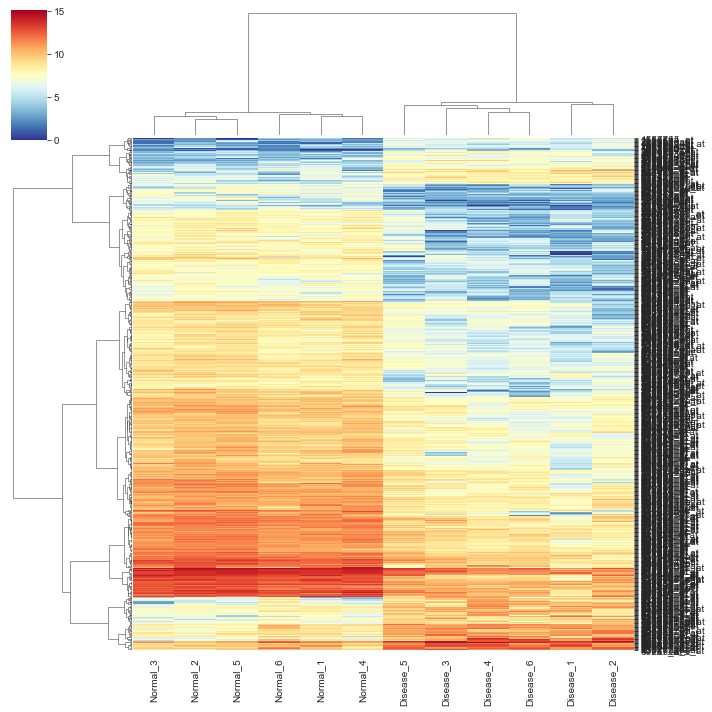

In [80]:
#plotting the heatmap with hierarchical clustering
sns.clustermap(exp_data, xticklabels=sample_names, yticklabels=genes, metric = "euclidean", method = "ward", cmap="RdYlBu_r")